# S1 Principles of Data Science - Coursework Submission
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

17th December 2023

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the S1 Principles of Data Science module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [S1 Principles of Data Science - Coursework Assignment](../DIS_MPhil_S1_Coursework_v2.2.pdf).


In [2]:
!pip install numpy
!pip install scipy
!pip install tabulate
!pip install pytest
!pip install numba_stats
!pip install iminuit
!pip install resample
!pip install matplotlib

In [3]:
# Import required libraries
import numpy as np
from scipy.stats import norm, expon
from scipy.integrate import quad
from scipy.special import erf
from tabulate import tabulate
import pytest
from numba_stats import truncexpon, truncnorm
from iminuit import Minuit, cost
from resample import bootstrap
from scipy.stats import chi2

# Set up matplotlib style and colours
import matplotlib.pyplot as plt
plt.style.use('sd2022.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'DejaVu Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'

# Set up some random seeds
seed_dob = 260699
seed_fave_song = 505
seed_football_number = 11

## SECTION A

### Question 1 (c)

__Given:__

Code these expressions for the probability density in python, in any way you so
desire. Plugging in some different values for the parameters 𝜽, use a numerical
integration to convince yourself that the total probability density integrates to unity
in the range 𝑀 ∈ [5,5.6]. 

__Answers:__

See answer in the associated code below.

In [5]:
# Define normalised background probability density function
def background_model(M, lb, Mrange):
    """Normalised background PDF (exponential decay)

    Computes the normalised background PDF for a given random variable, decay rate and range limit.

    Args:
        M (float): Random variable
        lb (float): Decay rate
        Mrange (tuple): Lower and upper range limit of the random variable
    
    Returns:
        float: Normalised background PDF for the given random variable
        
    """
    lower, upper = Mrange[0], Mrange[1]
    background = expon.pdf(M, scale=1/lb)
    N_b = (np.exp(-lb * lower) - np.exp(-lb * upper))
    return background / N_b

# Define normalised signal probability density function
def signal_model(M, mu, sigma, Mrange):
    """Normalised signal PDF (Gaussian)
    
    Computes the normalised signal PDF for a given random variable, mean and standard deviation.
    
    Args:
        M (float): Random variable
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable
        
    Returns:
        float: Normalised signal PDF for the given random variable 
    """
    lower, upper = Mrange[0], Mrange[1]
    signal = norm.pdf(M, loc=mu, scale=sigma)
    N_s = (1 / 2) * (erf((upper - mu) / (sigma * np.sqrt(2))) 
                     - erf((lower - mu) / (sigma * np.sqrt(2))))
    return signal / N_s

# Define normalised total probability density function
def total_model(M, f, lb, mu, sigma, Mrange):
    """Normalised total PDF (signal + background)

    Computes the normalised total PDF for a given random variable, decay rate, mean, 
    standard deviation and range limit.

    Args:
        M (float): Random variable
        f (float): Fraction of signal
        lb (float): Decay rate
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable
    
    Returns:
        float: Normalised total PDF for the given random variable
    """
    background = background_model(M, lb, Mrange)
    signal = signal_model(M, mu, sigma, Mrange)
    return (1-f) * background +  f * signal

# Define test ranges for parameters
f_tests = [0.1, 0.3, 0.5, 0.7, 0.9]
lb_tests = [0.2, 0.6, 1.0, 1.4, 1.8]
mu_tests = [5.1, 5.2, 5.3, 5.4, 5.5]
sigma_tests = [0.1,0.3, 0.5, 0.7, 0.9]

# Define lower and upper range limit of the numerical integration and the test tolerance level
alpha, beta = 5.0, 5.6
Mrange = (alpha, beta)
tolerance = 1e-6

# Iterate through different parameter combinations and calculate the integral of the total PDF
table_data = []
for f, lb, mu, sigma in zip(f_tests, lb_tests, mu_tests, sigma_tests):
    total_integral, _ = quad(total_model, *Mrange, args=(f, lb, mu, sigma, Mrange))
    test_result = "Passed" if total_integral == pytest.approx(1, abs=tolerance) else "Failed"
    table_row = [f, lb, mu, sigma, total_integral, test_result]
    table_data.append(table_row)

# Print the results using tabulate
headers = ["f", "lb", "mu", "sigma", "Integral", "Test Result"]
print(tabulate(table_data, headers=headers))
test_results = [row[-1] for row in table_data]

# Raise error if any tests failed
all_tests_passed = all(result == "Passed" for result in test_results)
assert all_tests_passed, "Not all tests passed"


  f    lb    mu    sigma    Integral  Test Result
---  ----  ----  -------  ----------  -------------
0.1   0.2   5.1      0.1           1  Passed
0.3   0.6   5.2      0.3           1  Passed
0.5   1     5.3      0.5           1  Passed
0.7   1.4   5.4      0.7           1  Passed
0.9   1.8   5.5      0.9           1  Passed


### Question 1 (d)

__Given:__

Assuming that the true values of the parameters, 𝜽=(𝑓,𝜆, 𝜇,𝜎), take the
following values 

𝑓 = 0.1, 𝜆 = 0.5, 𝜇 = 5.28, 𝜎 = 0.018

make a plot of the true signal, background and total probability distributions all
overlaid. 

__Answers:__

See answer in the associated code below.

Total, background and signal PDFs for f = 0.1, lb = 0.5, mu = 5.28 and sigma = 0.018: 


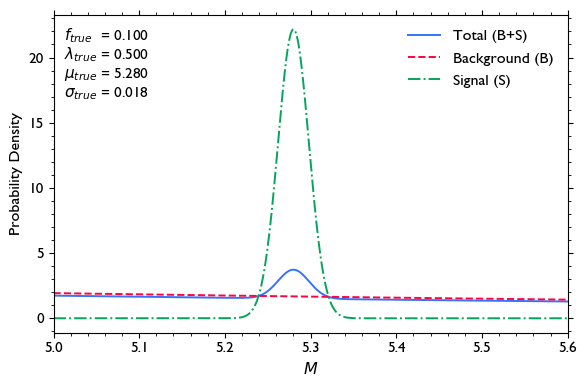

Total PDF and its background and signal component for f = 0.1, lb = 0.5, mu = 5.28 and sigma = 0.018: 


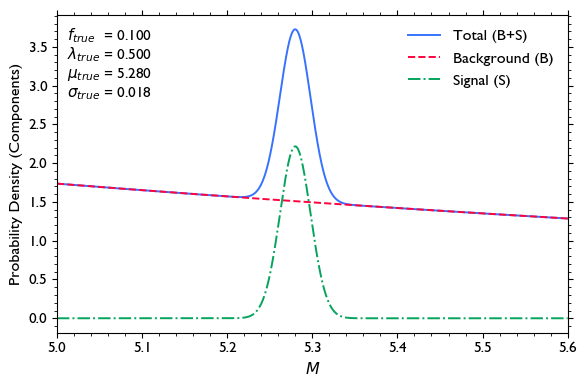

In [6]:
# Define the true values of the parameters 
f_true = 0.1
lb_true = 0.5
mu_true = 5.28
sigma_true = 0.018

# Generate values for the random variable 
n_vals = 100000
M_vals = np.linspace(*Mrange, n_vals)

# Calculate the background, signal and total PDF values
background_vals = background_model(M_vals, lb_true, Mrange)
background_vals_scaled = (1-f_true) * background_vals # scaled by background fraction
signal_vals = signal_model(M_vals, mu_true, sigma_true, Mrange)
signal_vals_scaled = f_true * signal_vals # scaled by signal fraction
total_vals = total_model(M_vals, f_true, lb_true, mu_true, sigma_true, Mrange)

# Plot the background, signal and total probability distributions
plt.figure()
plt.plot(M_vals, total_vals, linestyle = '-', label='Total (B+S)', color=sd2022_blue)
plt.plot(M_vals, background_vals, linestyle = '--', label='Background (B)', color=sd2022_red)
plt.plot(M_vals, signal_vals, linestyle = '-.', label='Signal (S)', color=sd2022_green)
plt.xlabel('$M$')
plt.ylabel('Probability Density')
plt.legend()
plt.text(0.02, 0.92, ("$f_{true}$" + f"  = {f_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.86, ("$\lambda_{true}$" + f" = {lb_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.80, ("$\mu_{true}$" + f" = {mu_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.74, ("$\sigma_{true}$" + f" = {sigma_true:.3f}"), transform=plt.gca().transAxes)
print(f"Total, background and signal PDFs for f = {f_true}, lb = {lb_true}, mu = {mu_true} and sigma = {sigma_true}: ")
plt.show()

# Plot the background, signal and total probability distributions (component fractions)
plt.figure()
plt.plot(M_vals, total_vals, linestyle = '-', label='Total (B+S)', color=sd2022_blue)
plt.plot(M_vals, background_vals_scaled, linestyle = '--', label='Background (B)', color=sd2022_red)
plt.plot(M_vals, signal_vals_scaled, linestyle = '-.', label='Signal (S)', color=sd2022_green)
plt.xlabel('$M$')
plt.ylabel('Probability Density (Components)')
plt.legend()
plt.text(0.02, 0.92, ("$f_{true}$" + f"  = {f_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.86, ("$\lambda_{true}$" + f" = {lb_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.80, ("$\mu_{true}$" + f" = {mu_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.74, ("$\sigma_{true}$" + f" = {sigma_true:.3f}"), transform=plt.gca().transAxes)
print(f"Total PDF and its background and signal component for f = {f_true}, lb = {lb_true}, mu = {mu_true} and sigma = {sigma_true}: ")
plt.show()


### Question 1 (e)

__Given:__

Assuming these true values, generate a single high-statistics sample
(containing 100K events) from this probability distribution. Use an estimation
method to obtain an estimate for the parameters of the model, along with
uncertainties on those estimates, using the generated sample. Make a plot which
shows the generated sample, along with the estimates of the signal, background
and total probability all overlaid.

__Answers:__

See answer in the associated code below.

In [7]:
# Redefine background, signal and total PDFs with in-built functions
def background_pdf(M, lb, Mrange):
    """Background PDF (exponential decay)

    Computes the background PDF for a given random variable, decay rate and range limit.

    Args:
        M (float): Random variable
        lb (float): Decay rate
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Background PDF for the given random variable
    """
    lower = Mrange[0]
    return truncexpon.pdf(M, *Mrange, loc = lower, scale=1/lb)

def signal_pdf(M, mu, sigma, Mrange):
    """Signal PDF (Gaussian)

    Computes the signal PDF for a given random variable, mean, standard deviation and range limit.

    Args:
        M (float): Random variable
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Signal PDF for the given random variable
    """
    return truncnorm.pdf(M, *Mrange, loc=mu, scale=sigma)

def total_pdf(M, f, lb, mu, sigma, Mrange):
    """Total PDF

    Computes the total PDF for a given random variable, decay rate, mean, standard deviation and 
    range limit.

    Args:
        M (float): Random variable
        f (float): Fraction of signal
        lb (float): Decay rate
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Total PDF for the given random variable
    """
    background = background_pdf(M, lb, Mrange)
    signal = signal_pdf(M, mu, sigma, Mrange)
    return (1-f) * background +  f * signal

# Define background, signal and total CDFs with in-built functions
def background_cdf(M, lb, Mrange):
    """Background CDF (exponential decay)

    Computes the background CDF for a given random variable, decay rate and range limit.

    Args:
        M (float): Random variable
        lb (float): Decay rate
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Background CDF for the given random variable
    """
    lower = Mrange[0]
    return truncexpon.cdf(M, *Mrange, loc = lower, scale=1/lb)

def signal_cdf(M, mu, sigma, Mrange):
    """Signal CDF (Gaussian)

    Computes the signal CDF for a given random variable, mean, standard deviation and range limit.

    Args:
        M (float): Random variable
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Signal CDF for the given random variable
    """
    return truncnorm.cdf(M, *Mrange, loc=mu, scale=sigma)

def total_cdf(M, f, lb, mu, sigma, Mrange):
    """Total CDF

    Computes the total CDF for a given random variable, decay rate, mean, standard deviation and
    range limit.

    Args:
        M (float): Random variable
        f (float): Fraction of signal
        lb (float): Decay rate
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Total CDF for the given random variable
    """
    background = background_cdf(M, lb, Mrange)
    signal = signal_cdf(M, mu, sigma, Mrange)
    return (1-f) * background +  f * signal

# Define background, signal and total PDF models (indepenent of range limits) for use in iminuit
def background_model_pdf(M, lb):
    return background_pdf(M, lb, Mrange)

def signal_model_pdf(M, lb):
    return signal_pdf(M, lb, Mrange)

def total_model_pdf(M, f, lb, mu, sigma):
    return total_pdf(M, f, lb, mu, sigma, Mrange)

# Define the numerical inverse CDF (PPF) method to generate samples
def generate_samples_ppf(n_samples, cdf_function, *args, xrange, seed=seed_dob):
    """Generate samples using the numerical inverse CDF (PPF) method

    Generates samples from a given probability distribution function (PDF) using the numerical
    inverse cumulative distribution function (CDF) method.

    Args:
        n_samples (int): Number of samples to generate
        cdf_function (function): CDF function
        *args: Arguments of the CDF function
        xrange (tuple): Lower and upper range limit of the random variable
        seed (int): Seed for reproducibility

    Returns:
        ndarray: Samples from the given PDF
    """
    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    # Generate n_samples uniform random numbers in [0, 1]
    uniform_vals = np.random.rand(n_samples)
    # Generate n_samples values in the range of the random variable [alpha, beta]
    x_vals = np.linspace(*xrange, n_samples)
    # Calculate the CDF values for the range of samples
    cdf_vals = cdf_function(*args)
    # Use linear interpolation to approximate the inverse CDF (PPF) and generate samples
    samples_ppf = np.interp(uniform_vals, cdf_vals, x_vals)
    return samples_ppf

Results from iminuit minimisation:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.096e+05                 │              Nfcn = 130              │
│ EDM = 1.74e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬───

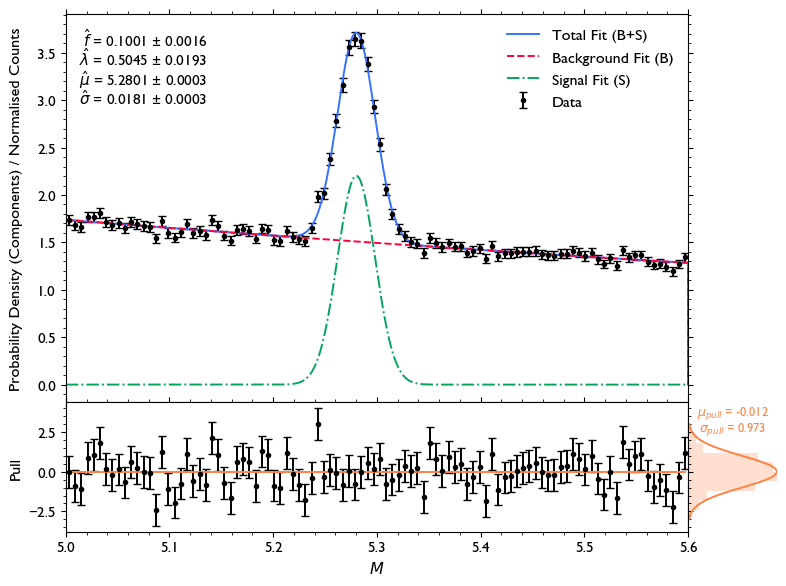

Mean of the pull distribution: -0.012
Standard deviation of the pull distribution: 0.973


In [7]:
# Generate high-statistics samples containing 100K events
n_samples = 100000
M_vals = np.linspace(*Mrange, n_samples) 
generated_data = generate_samples_ppf(n_samples, total_cdf, M_vals, f_true, lb_true, mu_true, sigma_true, Mrange, xrange = Mrange, seed=seed_dob)

# Define the negative log-likelihood (cost function) to be minimised
nll = cost.UnbinnedNLL(generated_data, total_model_pdf)

# Define the initial paramter values and limits (guesses)
f_init = 0.3
lb_init = 0.6
mu_init = 5.3
sigma_init = 0.03

# Construct the iminuit minimiser
mi = Minuit(nll, f=f_init, lb=lb_init, mu=mu_init, sigma=sigma_init)

# Define limits for parameters and fix lower and upper range limits
mi.limits['f'] = (0,1)
mi.limits['mu'] = (alpha,beta)

# Perform the minimisation and print results
mi.migrad()
mi.hesse() 
print('Results from iminuit minimisation:')
print(mi)

# Access the parameter estimates and errors
f_est = mi.values['f']
lb_est = mi.values['lb']
mu_est = mi.values['mu']
sigma_est = mi.values['sigma']
f_err = mi.errors['f']
lb_err = mi.errors['lb']
mu_err = mi.errors['mu']
sigma_err = mi.errors['sigma']

# Calculate the fitted background, signal and total PDF values (components)
background_fit_vals = (1-f_true) * background_pdf(M_vals, lb_est, Mrange)
signal_fit_vals = f_est * signal_pdf(M_vals, mu_est, sigma_est, Mrange)
total_fit_vals = total_pdf(M_vals, f_true, lb_est, mu_est, sigma_est, Mrange)

# Bin the data and calculate the normalised Poisson errors, residuals and pull
counts, bins = np.histogram(generated_data, bins=100, density=False, range = Mrange)
errors = np.sqrt(counts) # Poisson errors
bin_centers = (bins[:-1] + bins[1:])/2
bin_widths = np.diff(bins) 
counts_normalised = counts / (np.sum(counts) * bin_widths)
errors_normalised = errors / (np.sum(counts) * bin_widths)
bin_center_fits = total_pdf(bin_centers, f_est, lb_est, mu_est, sigma_est, Mrange)
residuals = counts_normalised - bin_center_fits
pull = residuals / errors_normalised 
pull_mean = np.mean(pull)
pull_sigma = np.std(pull)

# Plot a histogram of the generated sample data with normalised Poisson error bars
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey='row', sharex='col',
                gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))
ax[0,0].errorbar(bin_centers, counts_normalised, yerr=errors_normalised, fmt='.', color='black', label='Data')

# Plot the fitted background, signal and total probability distributions
ax[0,0].plot(M_vals, total_fit_vals, linestyle = '-', label='Total Fit (B+S)', color=sd2022_blue)
ax[0,0].plot(M_vals, background_fit_vals, linestyle = '--', label='Background Fit (B)', color=sd2022_red)
ax[0,0].plot(M_vals, signal_fit_vals, linestyle = '-.', label='Signal Fit (S)', color=sd2022_green)
ax[0,0].set_ylabel('Probability Density (Components) / Normalised Counts')

# Plot the pull
ax[1,0].errorbar(bin_centers, pull, yerr=np.ones_like(bin_centers), fmt='.',color='black')
ax[1,0].plot(bin_centers, np.zeros_like(bin_centers), linestyle='-', color=sd2022_orange)
ax[1,0].set_xlabel('$M$')
ax[1,0].set_ylabel('Pull')

# Plot the pull distribution
ax[0,1].set_visible(False)
ax[1,1].hist(pull, bins=10, range=(-3,3), density=True, alpha=0.25, orientation='horizontal', color=sd2022_orange)
ax[1,1].xaxis.set_visible(False)
ax[1,1].spines[['top','bottom','right']].set_visible(False)
ax[1,1].tick_params( which='both', direction='in', axis='y', right=False, labelcolor='none')
xp = np.linspace(-3,3,100)
ax[1,1].plot( norm.pdf(xp), xp, sd2022_orange)

# Include parameter estimates and errors in the plot
ax[0,0].text(-6.85, 3.75, f" $\hat{{f}}$ = {f_est:.4f} ± {f_err:.4f}", transform=plt.gca().transAxes)
ax[0,0].text(-6.85, 3.60, f"$\hat{{\lambda}}$ = {lb_est:.4f} ± {lb_err:.4f}", transform=plt.gca().transAxes)
ax[0,0].text(-6.85, 3.45, f"$\hat{{\mu}}$ = {mu_est:.4f} ± {mu_err:.4f}", transform=plt.gca().transAxes)
ax[0,0].text(-6.85, 3.30, f"$\hat{{\sigma}}$ = {sigma_est:.4f} ± {sigma_err:.4f}", transform=plt.gca().transAxes)
ax[0,0].autoscale(enable=True, tight=True, axis='x')
ax[0,0].legend()

# Include pull mean and sigma annotations in the plot
ax[1,1].text(0.5, 0.9, f"$\mu_{{pull}}$ = {pull_mean:.3f}", horizontalalignment='center', transform=ax[1,1].transAxes,size=9, color=sd2022_orange)
ax[1,1].text(0.5, 0.78, f"$\sigma_{{pull}}$ = {pull_sigma:.3f}", horizontalalignment='center', transform=ax[1,1].transAxes,size=9, color=sd2022_orange)
fig.align_ylabels()
print(f"Generated samples and estimates of the signal, background and total probability:")
plt.show()

print(f"Mean of the pull distribution: {pull_mean:.3f}")
print(f"Standard deviation of the pull distribution: {pull_sigma:.3f}")

## SECTION B

### Question 1 (f)

__Given:__

Assuming these true values, run a simulation study to estimate how much data
you would need to collect in order to “discover" the signal at least 90% of the time.
In other words generate some pretend datasets from the probability distribution
given and then see how easy it is to statistically infer the presence of a signal when
you fit those datasets back with the same model. You can assume that the threshold
for discovery is 5 standard deviations of a normal distribution, in other words a
𝑝-value of less than 2.9 ×10−7. You should assume that when fitting your
simulated samples that you have no a priori knowledge of any of the parameters
(in other words they should all float). Please justify and explain your approach in
your report write up.

__Answers:__

See answer in the associated code below.

In [8]:
# Bootstrap samples from null hypothesis (H0 : background only, i.e. f = 0) to find Chi2 dof
n_bootstrap = 100000
M_bootstrap = np.linspace(*Mrange, n_bootstrap)
data_bootstrap = generate_samples_ppf(n_bootstrap, total_cdf, M_bootstrap, 0,lb_true,mu_true,sigma_true, Mrange, xrange = Mrange,seed=seed_fave_song)
n_bootstrap_samples = 1000
bootstrap_samples = np.array([b for b in bootstrap.resample(data_bootstrap, size=n_bootstrap_samples, random_state=seed_football_number)])

# Calculate the test statistic for each bootstrap sample
T_list = []
for i in bootstrap_samples:

    # Construct the iminuit minimiser (Unbinned NLL) for H0
    nll_h0 = cost.UnbinnedNLL(i, total_model_pdf)
    mi_h0 = Minuit(nll_h0, f = f_init, lb=lb_init, mu=mu_init, sigma=sigma_init)

    # Run fit for the null hypothesis (H0 : background only, i.e. f = 0)
    mi_h0.values['f'] = 0
    mi_h0.fixed['f'] = True
    mi_h0.fixed['mu'] = True
    mi_h0.fixed['sigma'] = True
    mi_h0.migrad()
    mi_h0.hesse()
    h0_min = mi_h0.fval # minimum value of the cost function for H0

    # Construct the iminuit minimiser (Unbinned NLL) for H1
    nll_h1 = cost.UnbinnedNLL(i, total_model_pdf)
    mi_h1 = Minuit(nll_h1, f = f_init, lb=lb_init, mu=mu_init, sigma=sigma_init)

    # Run fit for alternative hypothesis (H1 : signal + background, i.e. f != 0)
    mi_h1.limits['f'] = (0.01,1) 
    mi_h1.limits['mu'] = (alpha,beta)
    mi_h1.migrad()
    mi_h1.hesse()
    h1_min = mi_h1.fval # minimum value of the cost function for H1

    # Calculate the test statistic
    T = h0_min - h1_min

    # Check if iminuit minimiser converged and append test statistic
    if mi.valid and T > 0:
        T_list.append(T)

E VariableMetricBuilder Initial matrix not pos.def.


Results from iminuit minimisation:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4403                       │              Nfcn = 25               │
│ EDM = 3.27e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────

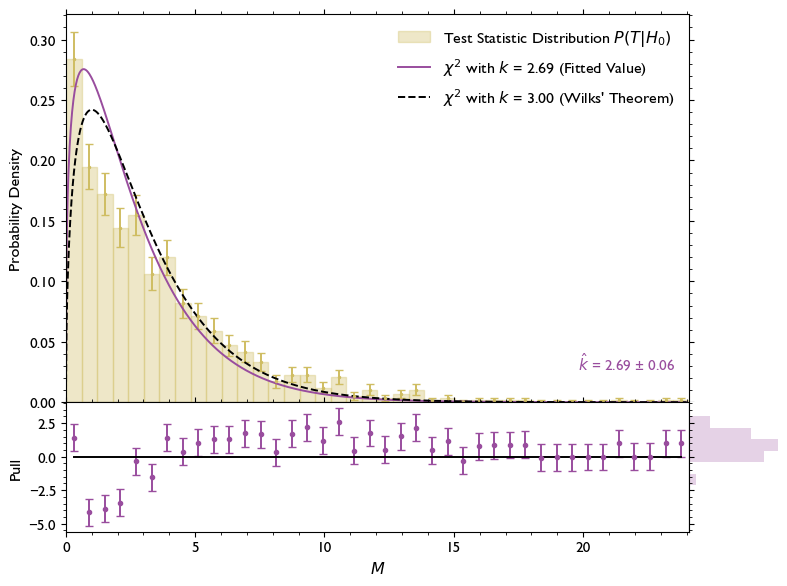

In [9]:
# Define Chi2 model
def chi2_model(T, dof):
    return chi2.pdf(T, dof)

# Construct the iminuit minimiser (Unbinned NLL)
enll_chi2 = cost.UnbinnedNLL(T_list,chi2_model)
mi_chi2 = Minuit(enll_chi2, dof=3) # initial guess for dof is 3.0 (Wilks' Theorem)

# Fit test statistic distribution to Chi2 distribution
mi_chi2.migrad()
mi_chi2.hesse()
print('Results from iminuit minimisation:')
print(mi_chi2)

# Access the degrees of freedom (dof) estimate and error
dof_est = mi_chi2.values['dof'] 
dof_err = mi_chi2.errors['dof']
print(f"Degrees of freedom estimate: {dof_est:.3f} ± {dof_err:.3f}")

# Calculate the fitted Chi2 PDF values
x_chi2 = np.linspace(0, 24, 1000) 
chi2_fit_vals = chi2.pdf(x = x_chi2, df = dof_est)
chi2_wilks = chi2.pdf(x = x_chi2, df = 3)
dof_display = "{:.2f}".format(dof_est)

# Bin the data and calculate the normalised Poisson errors, residuals and pull
number_of_bins = 40
counts, bins = np.histogram(T_list, bins=number_of_bins, density=False)
errors = np.sqrt(counts) # Poisson errors
errors[errors==0] = 1 # avoid division by zero
bin_centers = (bins[:-1] + bins[1:])/2
bin_widths = np.diff(bins) 
counts_normalised = counts / (np.sum(counts) * bin_widths)
errors_normalised = errors / (np.sum(counts) * bin_widths)
bin_center_fits = chi2.pdf(x = bin_centers, df = dof_est)
residuals = counts_normalised - bin_center_fits
pull = residuals / errors_normalised 

# Plot a histogram of the test statistic distribution with normalised Poisson error bars
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey='row', sharex='col',
                gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))
ax[0,0].hist(T_list, bins=number_of_bins, density=True, color=sd2022_gold, alpha=0.35, edgecolor=sd2022_gold, label="Test Statistic Distribution $P(T|H_0)$")
ax[0,0].errorbar(bin_centers, counts_normalised, yerr=errors_normalised, fmt='.', color=sd2022_gold, markersize=3)

# Plot the fitted Chi2 PDF values and Wilks' Theorem Chi2 PDF values
ax[0,0].plot(x_chi2, chi2_fit_vals, linestyle = '-',  label = ('$\chi^2$ with $k$ = ' + dof_display + ' (Fitted Value)'),color=sd2022_purple)
ax[0,0].plot(x_chi2, chi2_wilks, linestyle = '--',  label = ("$\chi^2$ with $k$ = 3.00 (Wilks' Theorem)"),color='black')
ax[0,0].set_ylabel('Probability Density')

# Plot the pull
ax[1,0].errorbar(bin_centers, pull, yerr=np.ones_like(bin_centers), fmt='.',color=sd2022_purple)
ax[1,0].plot(bin_centers, np.zeros_like(bin_centers), linestyle='-', color='black')
ax[1,0].set_xlabel('$M$')
ax[1,0].set_ylabel('Pull')

# Plot the pull distribution
ax[0,1].set_visible(False)
ax[1,1].hist(pull, bins=7, range=(-3,3), density=True, alpha=0.25, orientation='horizontal', color=sd2022_purple)
ax[1,1].xaxis.set_visible(False)
ax[1,1].spines[['top','bottom','right']].set_visible(False)
ax[1,1].tick_params( which='both', direction='in', axis='y', right=False, labelcolor='none')

# Include parameter estimates and errors in the plot
ax[1,1].text(-1.25,1.25, f"$\hat{{k}}$ = {dof_est:.2f} ± {dof_err:.2f}", transform=plt.gca().transAxes, color=sd2022_purple)
ax[0,0].autoscale(enable=True, tight=True, axis='x')
ax[0,0].legend()

# Show the plot
fig.align_ylabels()
ax[0,0].set_ylim(bottom=0)
print(f"Test statistic distribution and Chi-squared fit:")
plt.show()


Number of events required to reach a discovery rate of 90%: 720


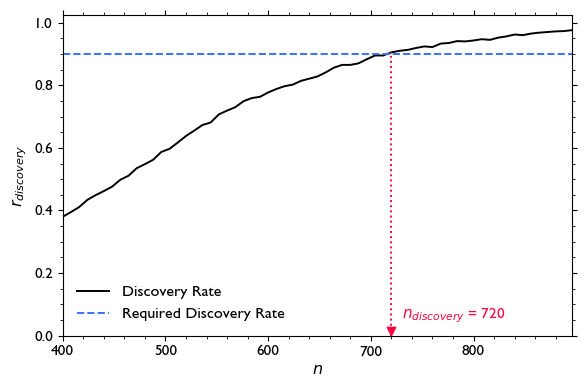

In [10]:
# Define the p-value calculator function for Question f)
def pval_calculator_f(dataset, chi2_dof): 
    """P-value calculator (Question f)

    Calculates the p-value for a given dataset and degrees of freedom (dof) estimate.

    Args:
        dataset (ndarray): Dataset
        chi2_dof (float): Degrees of freedom (dof) estimate

    Returns:
        float: p-value
    """
    # Construct the iminuit minimiser (Unbinned NLL)
    nll = cost.UnbinnedNLL(dataset, total_model_pdf)
    minu = Minuit(nll, f=f_init, lb=lb_init, mu=mu_init, sigma=sigma_init)
    # Run fit for the null hypothesis (H0 : background only, i.e. f = 0)
    minu.values['f'] = 0
    minu.fixed['f'] = True
    minu.fixed["mu"] = True
    minu.fixed["sigma"] = True
    minu.migrad()
    minu.hesse()
    h0_min = minu.fval # minimum value of the cost function for H0
    # Run fit for the alternative hypothesis (H1 : signal + background, i.e. f != 0)
    minu.values['f'] = f_init
    minu.limits['f'] = (0,1)
    minu.fixed['f'] = False
    minu.fixed["mu"] = False
    minu.fixed["sigma"] = False
    minu.limits['mu'] = (alpha,beta)
    minu.migrad()
    minu.hesse()
    h1_min = minu.fval # minimum value of the cost function for H1
    # Calculate the test statistic and p-value
    T = h0_min - h1_min
    p_value = chi2.sf(T,chi2_dof) # 1 - chi2.cdf(T,chi2_dof)
    return p_value

# Load degree of freedom (dof) estimate from bootstrap test
try:
    chi2_dof_est = dof_est
except NameError:
    chi2_dof_est = 2.69 # previously calculated value

# Define the n_discovery estimator function for Question f)
def ndiscovery_calculator_f(N_list, seeds, p_value_threshold, discovery_threshold):
    """n_discovery estimator (Question f)

    Calculates the number of events required to reach a discovery rate of 90% for a given list of
    n values, seeds, p-value threshold and discovery threshold.

    Args:
        N_list (list): List of n values
        seeds (list): List of seeds
        p_value_threshold (float): p-value threshold
        discovery_threshold (float): Discovery threshold

    Returns:
        int: Number of events required to reach a discovery rate of 90%
        float: Discovery rate result
        list: List of discovery rates for each n value
    """
    # Calculate the discovery rate for each n value and seed
    discovery_rate_list = []
    for N in N_list:
        M_gen = np.linspace(*Mrange, N)
        p_value_list = []
        for seed in seeds:
            # Generate pseudo-data 
            dataset = generate_samples_ppf(N, total_cdf, M_gen, f_true, lb_true, mu_true, 
                                        sigma_true, Mrange, xrange = Mrange, seed=seed)
            # Calculate the p-value 
            p_value = pval_calculator_f(dataset, chi2_dof_est)
            p_value_list.append(p_value)
        # Calculate the discovery rate for each n value
        p_value_array = np.array(p_value_list)
        discovery_rate = np.sum(p_value_array < p_value_threshold) / len(p_value_array)
        discovery_rate_list.append(discovery_rate)
    # Find the n value at which the discovery rate is greater than 90%
    N_discovery_index =  np.where(
        np.array(discovery_rate_list) > discovery_threshold)[0][0]
    N_discovery = N_list[N_discovery_index]
    discovery_rate_result = discovery_rate_list[N_discovery_index]
    return N_discovery, discovery_rate_result, discovery_rate_list

# Run simulation to find the number of events required to reach a discovery rate of 90%
step_size = 8
N_list = np.arange(400, 901,step_size)
seeds = np.arange(0, 1000)
p_value_threshold = 2.9 * 1e-07
discovery_threshold = 0.9
N_discovery, discovery_rate_result, discovery_rate_list = ndiscovery_calculator_f(N_list, seeds, p_value_threshold, discovery_threshold)

print(f"Number of events required to reach a discovery rate of 90%: {N_discovery}")
     
# Plot the simulation results
plt.figure()
plt.plot(N_list, discovery_rate_list, linestyle = '-', label='Discovery Rate', color='black')
plt.plot(N_list,np.ones_like(N_list)*discovery_threshold,linestyle = '--', label='Required Discovery Rate', color=sd2022_blue)
plt.plot([N_discovery,N_discovery],[0,discovery_rate_result], linestyle=':', color=sd2022_red)
plt.scatter(N_discovery, 0.015, marker='v', color=sd2022_red)
plt.text(N_discovery + 10, 0.055, '$n_{discovery}$ = ' + str(N_discovery), color=sd2022_red)
plt.ylim(bottom=0)
plt.xlabel('$n$')
plt.ylabel('$r_{discovery}$')
plt.legend()
plt.show()

### Question 1 (g)

__Given:__

Let us now assume there is a second signal which has the same probability density function as the first signal but with its mean position shifted with respect to the first signal. We can now write our total probability density as

𝑝(𝑀) = 𝑓1 𝑠1(𝑀;𝜇1,𝜎)+ 𝑓2 𝑠2(𝑀;𝜇2,𝜎) + (1− 𝑓1 − 𝑓2) 𝑏(𝑀;𝜆),

where 𝑓1 and 𝑓2 are the fraction of each signal, 𝜇1 and 𝜇2 their mean positions, 𝜎 is the same width for both signals and 𝜆 is as before. You can assume that the true values of the parmaeters are,

𝑓1 =0.1, 𝑓2 =0.05, 𝜆=0.5, 𝜇1 =5.28, 𝜇2 =5.35, 𝜎=0.018.

Determine how much data would be needed in order to determine (at 5 standard deviations) that there are two separate signals (not a single overlapping signal) at
least 90% of the time. Please justify and explain your approach in your report
write up.

__Answers:__

See answer in the associated code below.

In [231]:
# Define single and double signal cumulative density functions with in-built functions
def background_cdf(M, lb, Mrange):
    """Background CDF (exponential decay)

    Computes the background CDF for a given random variable, decay rate and range limit.

    Args:
        M (float): Random variable
        lb (float): Decay rate
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Background CDF for the given random variable
    """
    lower = Mrange[0]
    return truncexpon.cdf(M, *Mrange, loc = lower, scale=1/lb)

def signal_cdf(M, mu, sigma, Mrange):
    """Signal CDF (Gaussian)

    Computes the signal CDF for a given random variable, mean, standard deviation and range limit.

    Args:
        M (float): Random variable
        mu (float): Mean
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Signal CDF for the given random variable
    """
    return truncnorm.cdf(M, *Mrange, loc=mu, scale=sigma)

def total_single_signal_cdf(M, f1, lb, mu1, sigma, Mrange):
    """Total CDF (single signal)
    
    Computes the total CDF for a given random variable, decay rate, mean, standard deviation and
    range limit.
    
    Args:
        M (float): Random variable
        f1 (float): Fraction of signal 1
        lb (float): Decay rate
        mu1 (float): Mean of signal 1
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable
        
    Returns:
        float: Total CDF for the given random variable
    """
    background = background_cdf(M, lb, Mrange)
    signal1 = signal_cdf(M, mu1, sigma, Mrange)
    return (1-f1) * background +  f1 * signal1

def total_double_signal_cdf(M, f1, f2, lb, mu1, mu2, sigma, Mrange):
    """Total CDF (double signal)

    Computes the total CDF for a given random variable, decay rate, mean, standard deviation and
    range limit.

    Args:
        M (float): Random variable
        f1 (float): Fraction of signal 1
        f2 (float): Fraction of signal 2
        lb (float): Decay rate
        mu1 (float): Mean of signal 1
        mu2 (float): Mean of signal 2
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Total CDF for the given random variable
    """
    background = background_cdf(M, lb, Mrange)
    signal1 = signal_cdf(M, mu1, sigma, Mrange)
    signal2 = signal_cdf(M, mu2, sigma, Mrange)
    return (1-f1-f2) * background +  f1 * signal1 + f2 * signal2

# Define single and double signal CDF models (for use in iminuit)
def total_single_signal_model_cdf(M, f1, lb, mu1, sigma):
    return total_single_signal_cdf(M, f1, lb, mu1, sigma, Mrange)

def total_double_signal_model_cdf(M, f1, f2, lb, mu1, mu2, sigma):
    return total_double_signal_cdf(M, f1, f2, lb, mu1, mu2, sigma, Mrange)

# Define single and double signal probability density function with in-built functions
def total_single_signal_pdf(M, f1, lb, mu1, sigma, Mrange):
    """Total PDF (single signal)
    
    Computes the total PDF for a given random variable, decay rate, mean, standard deviation and
    range limit.
    
    Args:
        M (float): Random variable
        f1 (float): Fraction of signal 1
        lb (float): Decay rate
        mu1 (float): Mean of signal 1
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable
        
    Returns:
        float: Total PDF for the given random variable
    """
    background = background_pdf(M, lb, Mrange)
    signal1 = signal_pdf(M, mu1, sigma, Mrange)
    return (1-f1) * background +  f1 * signal1

def total_double_signal_pdf(M, f1, f2, lb, mu1, mu2, sigma, Mrange):
    """Total PDF (double signal)

    Computes the total PDF for a given random variable, decay rate, mean, standard deviation and
    range limit.

    Args:
        M (float): Random variable
        f1 (float): Fraction of signal 1
        f2 (float): Fraction of signal 2
        lb (float): Decay rate
        mu1 (float): Mean of signal 1
        mu2 (float): Mean of signal 2
        sigma (float): Standard deviation
        Mrange (tuple): Lower and upper range limit of the random variable

    Returns:
        float: Total PDF for the given random variable
    """
    background = background_pdf(M, lb, Mrange)
    signal1 = signal_pdf(M, mu1, sigma, Mrange)
    signal2 = signal_pdf(M, mu2, sigma, Mrange)
    return (1-f1-f2) * background +  f1 * signal1 + f2 * signal2

# Define single and double signal PDF models (for use in iminuit)
def total_single_signal_model_pdf(M, f1, lb, mu1, sigma):
    return total_single_signal_pdf(M, f1, lb, mu1, sigma, Mrange)

def total_double_signal_model_pdf(M, f1, f2, lb, mu1, mu2, sigma):
    return total_double_signal_pdf(M, f1, f2, lb, mu1, mu2, sigma, Mrange)

Total PDF and its background and signal component for f1 = 0.1, f2 = 0.05, lb = 0.5, mu1 = 5.28, mu2 = 5.35 and sigma = 0.018


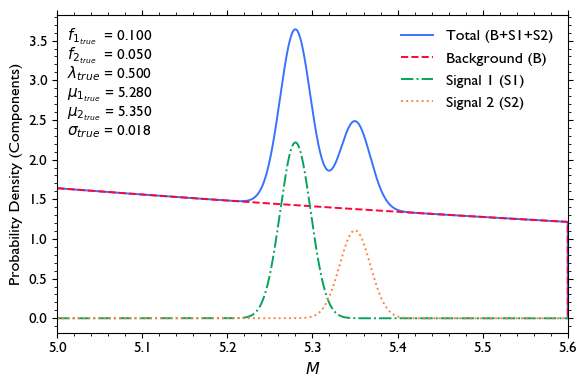

In [232]:
# Define the true values of the parameters 
f1_true = 0.1
f2_true = 0.05
lb_true = 0.5
mu1_true = 5.28
mu2_true = 5.35
sigma_true = 0.018

# Generate values for the random variable 
n_vals = 100000
M_vals = np.linspace(*Mrange, n_vals)

# Calculate the background, first signal, second signal and total PDF values
background_vals = background_pdf(M_vals, lb_true, Mrange)
background_vals_scaled = (1-f1_true-f2_true) * background_vals # scaled by background fraction
signal_1_vals = signal_pdf(M_vals, mu1_true, sigma_true, Mrange)
signal_1_vals_scaled = f1_true * signal_1_vals # scaled by signal 1 fraction
signal_2_vals = signal_pdf(M_vals, mu2_true, sigma_true, Mrange)
signal_2_vals_scaled = f2_true * signal_2_vals # scaled by signal 1 and 2 fractions
total_vals = total_double_signal_pdf(M_vals, f1_true, f2_true, lb_true, mu1_true, mu2_true, sigma_true, Mrange)

# Plot the background, signal and total probability distributions (component fractions)
plt.figure()
plt.plot(M_vals, total_vals, linestyle = '-', label='Total (B+S1+S2)', color=sd2022_blue)
plt.plot(M_vals, background_vals_scaled, linestyle = '--', label='Background (B)', color=sd2022_red)
plt.plot(M_vals, signal_1_vals_scaled, linestyle = '-.', label='Signal 1 (S1)', color=sd2022_green)
plt.plot(M_vals, signal_2_vals_scaled, linestyle = ':', label='Signal 2 (S2)', color=sd2022_orange)
plt.xlabel('$M$')
plt.ylabel('Probability Density (Components)')
plt.legend()
plt.text(0.02, 0.92, ("$f_{1_{true}}$" + f"  = {f1_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.86, ("$f_{2_{true}}$" + f"  = {f2_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.80, ("$\lambda_{true}$" + f" = {lb_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.74, ("$\mu_{1_{true}}$" + f" = {mu1_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.68, ("$\mu_{2_{true}}$" + f" = {mu2_true:.3f}"), transform=plt.gca().transAxes)
plt.text(0.02, 0.62, ("$\sigma_{true}$" + f" = {sigma_true:.3f}"), transform=plt.gca().transAxes)
print(f"Total PDF and its background and signal component for f1 = {f1_true}, f2 = {f2_true}, lb = {lb_true}, mu1 = {mu1_true}, mu2 = {mu2_true} and sigma = {sigma_true}")
plt.show()

In [233]:
# Bootstrap samples from null hypothesis (H0 : 1 signal + background, i.e. f_2 = 0) to find Chi2 dof
n_bootstrap = 100000
M_bootstrap = np.linspace(*Mrange, n_bootstrap)
data_bootstrap = generate_samples_ppf(n_bootstrap, total_double_signal_cdf, M_bootstrap, f1_true,0,lb_true,mu1_true,mu2_true,sigma_true, Mrange, xrange = Mrange, seed = seed_fave_song)
n_bootstrap_samples = 1000
bootstrap_samples = np.array( [ b for b in bootstrap.resample(data_bootstrap, size=n_bootstrap_samples, random_state=seed_football_number) ] )

# Calculate the test statistic for each bootstrap sample
T_list2 = []
for i in bootstrap_samples:

    # Construct the iminuit minimiser the null hypothesis (H0 : 1 signal + background, i.e. f2 = 0)
    nll = cost.UnbinnedNLL(i, total_single_signal_model_pdf)
    minu = Minuit(nll, f1=0.15, lb=0.6, mu1=5.2, sigma=0.03)
    minu.limits['f1'] = (0.01,1)
    minu.limits['mu1'] = (alpha,beta)

    # Run fit for the null hypothesis (H0 : 1 signal + background, i.e. f2 = 0)
    minu.migrad()
    minu.hesse()
    h0_min = minu.fval # minimum value of the cost function for H0

    # Construct the iminuit minimiser for the alternative hypothesis (H1 : 2 signals + background, i.e. f2 != 0)
    nll = cost.UnbinnedNLL(i, total_double_signal_model_pdf)
    minu = Minuit(nll, f1=0.15, f2=0.10, lb=0.6, mu1=5.2, mu2=5.3, sigma=0.03)
    minu.limits['f1'] = (0.01,1)
    minu.limits['f2'] = (0.01,1)
    minu.limits['mu1'] = (alpha,beta)
    minu.limits['mu2'] = (alpha,beta)

    # Run fit for the alternative hypothesis (H1 : 2 signals + background, i.e. f2 != 0)
    minu.migrad()
    minu.hesse()
    h1_min = minu.fval # minimum value of the cost function for H1

    # Calculate the test statistic
    T = h0_min - h1_min

    # Check if iminuit minimiser converged and append test statistic
    if mi.valid and T > 0:
        T_list2.append(T)
        

Results from iminuit minimisation:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2923                       │              Nfcn = 23               │
│ EDM = 2.41e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────

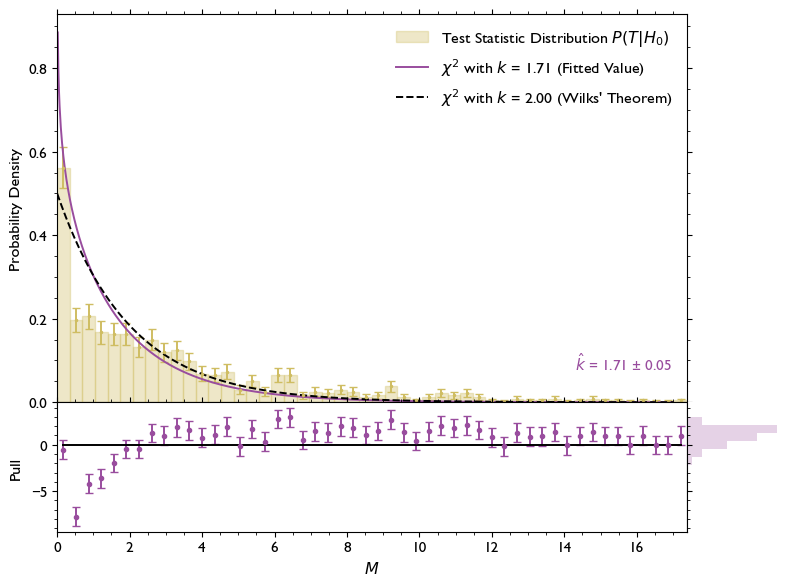

In [234]:
# Define Chi2 model
def chi2_model(T, dof):
    return chi2.pdf(T, dof)

# Construct the iminuit minimiser (Unbinned NLL)
enll_chi2 = cost.UnbinnedNLL(T_list2,chi2_model)
mi_chi2 = Minuit(enll_chi2, dof=2) # initial guess for dof is 2.0 (Wilks' Theorem)

# Fit test statistic distribution to Chi2 distribution
mi_chi2.migrad()
mi_chi2.hesse()
print('Results from iminuit minimisation:')
print(mi_chi2)

# Access the degrees of freedom (dof) estimate and error
dof_est2 = mi_chi2.values['dof'] 
dof_err2 = mi_chi2.errors['dof']
print(f"Degrees of freedom estimate: {dof_est2:.3f} ± {dof_err2:.3f}")

# Calculate the fitted Chi2 PDF values
x_chi2 = np.linspace(0, 17, 1000) 
chi2_fit_vals = chi2.pdf(x = x_chi2, df = dof_est2)
chi2_wilks = chi2.pdf(x = x_chi2, df = 2)
dof_display = "{:.2f}".format(dof_est2)

# Bin the data and calculate the normalised Poisson errors, residuals and pull
number_of_bins = 50
counts, bins = np.histogram(T_list2, bins=number_of_bins, density=False)
errors = np.sqrt(counts) # Poisson errors
errors[errors==0] = 1 # avoid division by zero
bin_centers = (bins[:-1] + bins[1:])/2
bin_widths = np.diff(bins) 
counts_normalised = counts / (np.sum(counts) * bin_widths)
errors_normalised = errors / (np.sum(counts) * bin_widths)
bin_center_fits = chi2.pdf(x = bin_centers, df = dof_est2)
residuals = counts_normalised - bin_center_fits
pull = residuals / errors_normalised 

# Plot a histogram of the test statistic distribution with normalised Poisson error bars
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey='row', sharex='col',
                gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))
ax[0,0].hist(T_list2, bins=number_of_bins, density=True, color=sd2022_gold, alpha=0.35, edgecolor=sd2022_gold, label="Test Statistic Distribution $P(T|H_0)$")
ax[0,0].errorbar(bin_centers, counts_normalised, yerr=errors_normalised, fmt='.', color=sd2022_gold, markersize=3)

# Plot the fitted Chi2 PDF values and Wilks' Theorem Chi2 PDF values
ax[0,0].plot(x_chi2, chi2_fit_vals, linestyle = '-',  label = ('$\chi^2$ with $k$ = ' + dof_display + ' (Fitted Value)'),color=sd2022_purple)
ax[0,0].plot(x_chi2, chi2_wilks, linestyle = '--',  label = ("$\chi^2$ with $k$ = 2.00 (Wilks' Theorem)"),color='black')
ax[0,0].set_ylabel('Probability Density')

# Plot the pull
ax[1,0].errorbar(bin_centers, pull, yerr=np.ones_like(bin_centers), fmt='.',color=sd2022_purple)
ax[1,0].plot(bin_centers, np.zeros_like(bin_centers), linestyle='-', color='black')
ax[1,0].set_xlabel('$M$')
ax[1,0].set_ylabel('Pull')

# Plot the pull distribution
ax[0,1].set_visible(False)
ax[1,1].hist(pull, bins=7, range=(-3,3), density=True, alpha=0.25, orientation='horizontal', color=sd2022_purple)
ax[1,1].xaxis.set_visible(False)
ax[1,1].spines[['top','bottom','right']].set_visible(False)
ax[1,1].tick_params( which='both', direction='in', axis='y', right=False, labelcolor='none')

# Include parameter estimates and errors in the plot
ax[1,1].text(-1.25,1.25, f"$\hat{{k}}$ = {dof_est2:.2f} ± {dof_err2:.2f}", transform=plt.gca().transAxes, color=sd2022_purple)
ax[0,0].autoscale(enable=True, tight=True, axis='x')
ax[0,0].legend()

# Show the plot
fig.align_ylabels()
ax[0,0].set_ylim(bottom=0)
print(f"Test statistic distribution and Chi-squared fit:")
plt.show()

Number of events required to reach a discovery rate of 90%: 3552


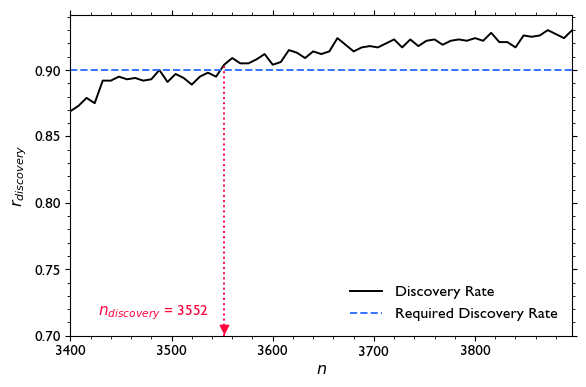

In [235]:
# Define the p-value calculator function for Question g)
def pval_calculator_g(counts, bins, chi2_dof): 
    """P-value calculator (Question g)

    Calculates the p-value for a given dataset and degrees of freedom (dof) estimate.

    Args:
        counts (ndarray): Counts
        bins (ndarray): Bins
        chi2_dof (float): Degrees of freedom (dof) estimate

    Returns:
        float: p-value
    """
    # Construct the iminuit minimiser the null hypothesis (H0 : 1 signal + background, i.e. f2 = 0)
    nll = cost.BinnedNLL(counts,bins, total_single_signal_model_cdf)
    minu = Minuit(nll, f1=0.15, lb=0.6, mu1=5.2, sigma=0.03)
    minu.limits['f1'] = (0.01,1)
    minu.limits['mu1'] = (alpha,beta)
    # Run fit for the null hypothesis (H0 : 1 signal + background, i.e. f2 = 0)
    minu.migrad()
    minu.hesse()
    h0_min = minu.fval # minimum value of the cost function for H0
    # Construct the iminuit minimiser for the alternative hypothesis (H1 : 2 signals + background, i.e. f2 != 0)
    nll = cost.BinnedNLL(counts,bins, total_double_signal_model_cdf)
    minu = Minuit(nll, f1=0.15, f2=0.10, lb=0.6, mu1=5.2, mu2=5.3, sigma=0.03)
    minu.limits['f1'] = (0.01,1)
    minu.limits['f2'] = (0.01,1)
    minu.limits['mu1'] = (alpha,beta)
    minu.limits['mu2'] = (alpha,beta)
    # Run fit for the alternative hypothesis (H1 : 2 signals + background, i.e. f2 != 0)
    minu.migrad()
    minu.hesse()
    h1_min = minu.fval # minimum value of the cost function for H1
    # Calculate the test statistic
    T = h0_min - h1_min
    p_value = chi2.sf(T,chi2_dof) 
    return p_value

# Load degree of freedom (dof) estimate from bootstrap test
try:
    chi2_dof_est2 = dof_est2
except NameError:
    chi2_dof_est2 =  1.71 # previously calculated value

from scipy.stats import chi2

# Define the n_discovery estimator function for Question g)
def ndiscovery_calculator_g(N_list, seeds, p_value_threshold, discovery_threshold): 
    """n_discovery estimator (Question g)

    Calculates the number of events required to reach a discovery rate of 90% for a given list of
    n values, seeds, p-value threshold and discovery threshold.

    Args:
        N_list (list): List of n values
        seeds (list): List of seeds
        p_value_threshold (float): p-value threshold
        discovery_threshold (float): Discovery threshold

    Returns:
        int: Number of events required to reach a discovery rate of 90%
        float: Discovery rate result
        list: List of discovery rates for each n value
    """
    # Calculate the discovery rate for each n value and seed
    discovery_rate_list = []
    for N in N_list:
        M_gen = np.linspace(*Mrange, N)
        p_value_list = []
        for seed in seeds:
            # Generate pseudo-data 
            dataset = generate_samples_ppf(N, total_double_signal_cdf, M_gen, f1_true,
                                           f2_true,lb_true, mu1_true, mu2_true, 
                                           sigma_true, Mrange, xrange = Mrange, seed=seed)
            counts, bins = np.histogram(dataset, bins=500, density=False, range = Mrange)
            # Calculate the p-value 
            p_value = pval_calculator_g(counts, bins, chi2_dof_est)
            p_value_list.append(p_value)
        # Calculate the discovery rate for each n value
        p_value_array = np.array(p_value_list)
        discovery_rate = np.sum(p_value_array < p_value_threshold) / len(p_value_array)
        discovery_rate_list.append(discovery_rate)
    # Find the n value at which the discovery rate is greater than 90%
    N_discovery_index =  np.where(
        np.array(discovery_rate_list) > discovery_threshold)[0][0]
    N_discovery = N_list[N_discovery_index]
    discovery_rate_result = discovery_rate_list[N_discovery_index]
    return N_discovery, discovery_rate_result, discovery_rate_list

# Run simulation to find the number of events required to reach a discovery rate of 90%
step_size = 8
N_list = np.arange(3400, 3901,step_size)
seeds = np.arange(0, 1000)
p_value_threshold = 2.9 * 1e-07
discovery_threshold = 0.9
N_discovery, discovery_rate_result, discovery_rate_list = ndiscovery_calculator_g(N_list, seeds, p_value_threshold, discovery_threshold)

print(f"Number of events required to reach a discovery rate of 90%: {N_discovery}")
     
# Plot the simulation results
plt.figure()
plt.plot(N_list, discovery_rate_list, linestyle = '-', label='Discovery Rate', color='black')
plt.plot(N_list,np.ones_like(N_list)*discovery_threshold,linestyle = '--', label='Required Discovery Rate', color=sd2022_blue)
plt.plot([N_discovery,N_discovery],[0.7,discovery_rate_result], linestyle=':', color=sd2022_red)
plt.scatter(N_discovery, 0.705, marker='v', color=sd2022_red)
plt.text(N_discovery - 125, 0.715, '$n_{discovery}$ = ' + str(N_discovery), color=sd2022_red)
plt.ylim(bottom=0.7)
plt.xlabel('$n$')
plt.ylabel('$r_{discovery}$')
plt.legend(loc='lower right')
plt.show()